## MODELOS DE CLASIFICACION
### Laboratorio #4 – Modelos de Clasificacion
### Marcos Alexander Muchuch Simon - 13218020

# RESUMEN DEL CODIGO EN CLASES

Importación de librerías y carga de datos

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, KFold
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

# El dataframe se subien en linea. 
df = pd.read_csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vQQcTXm1F3u8Qj8T5sZpQVjeLfUtUSq4dbqjxnABNkKg5sjxqvRY8N4pMLSdFMJuDEuAjwQQ3C6BN1n/pub?output=csv")


2. Análisis exploratorio de datos y preprocesamiento

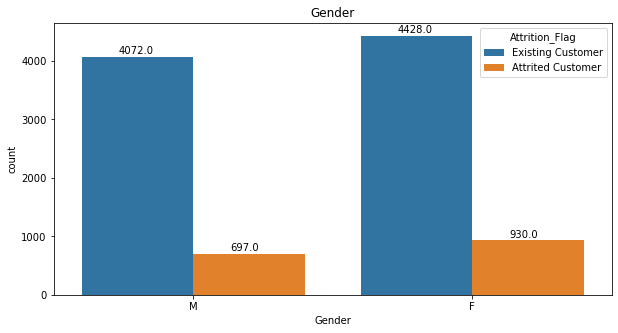

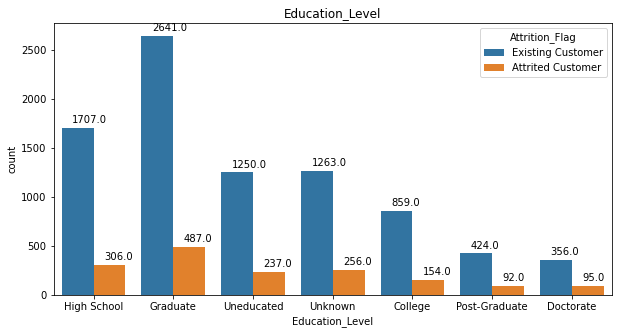

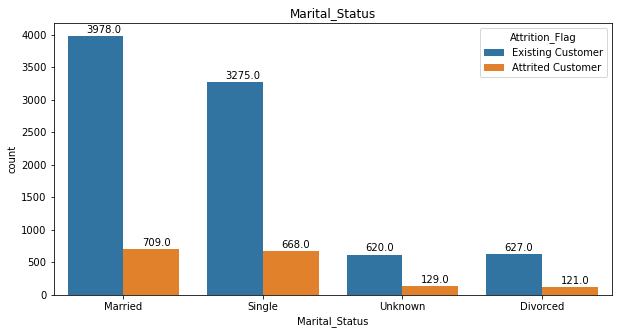

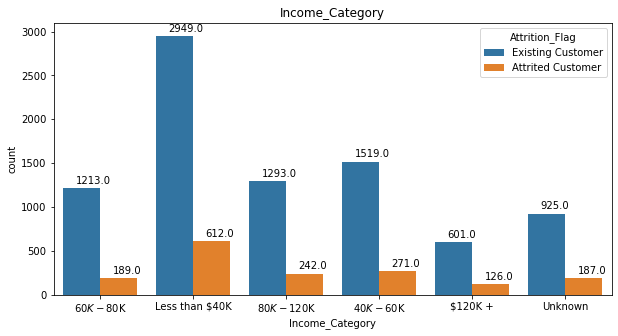

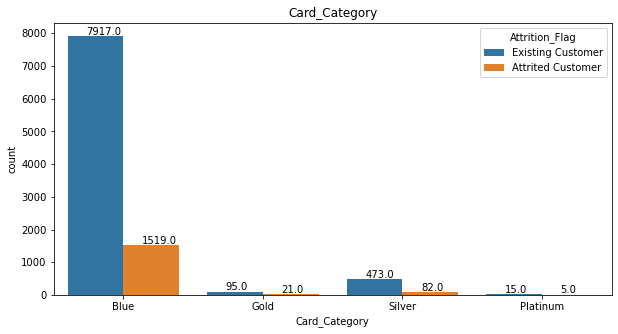

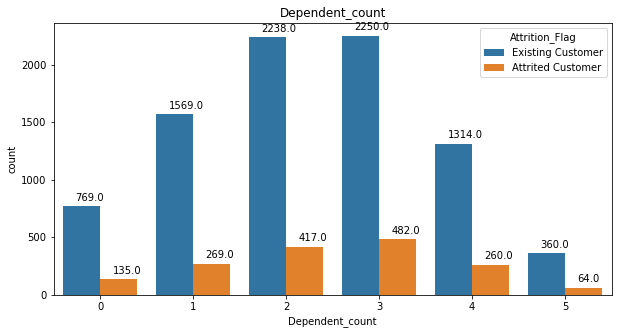

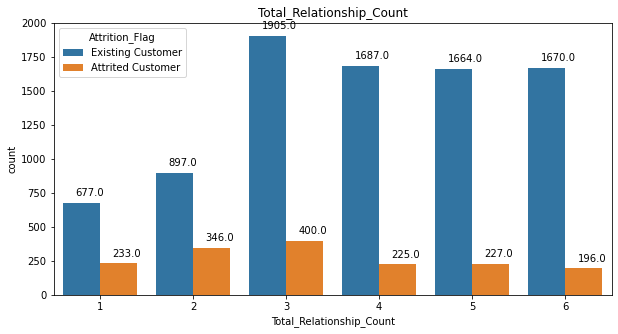

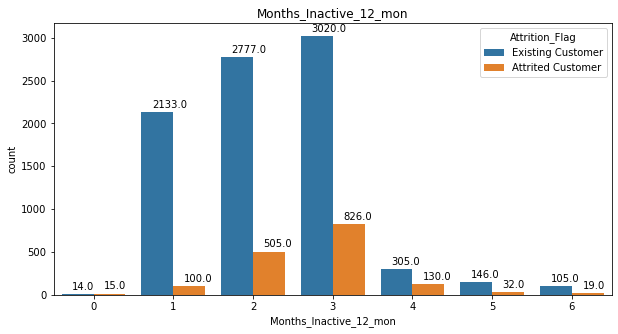

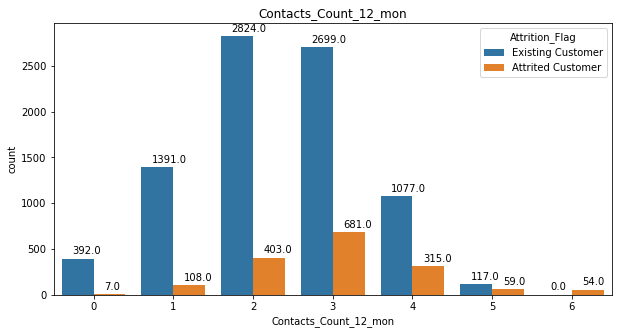

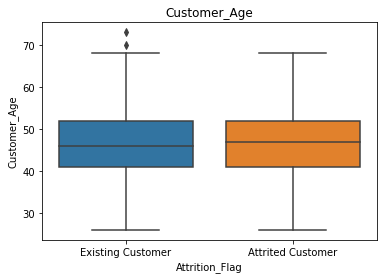

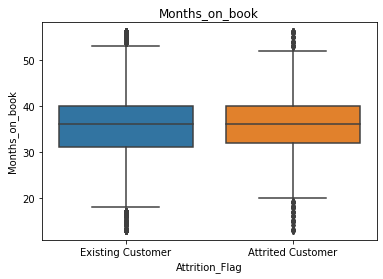

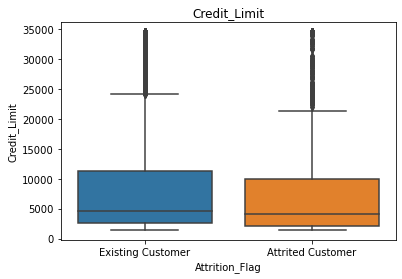

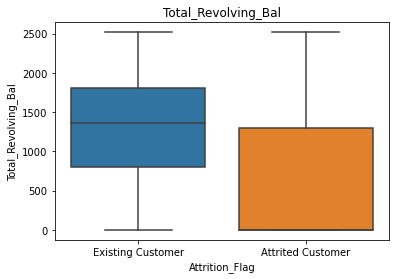

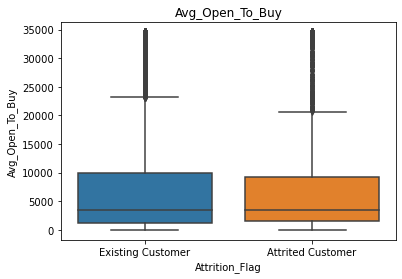

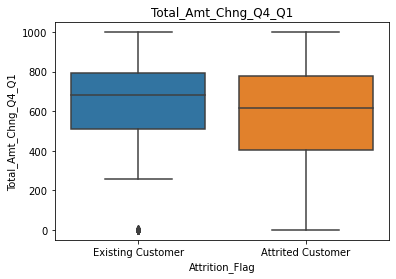

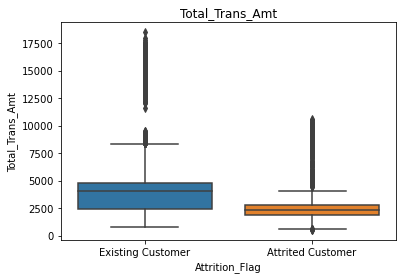

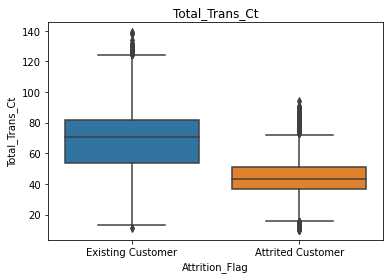

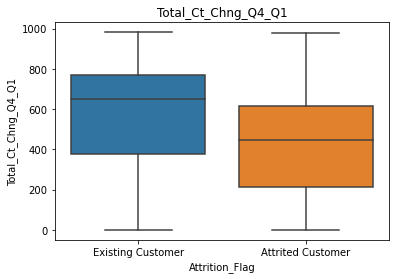

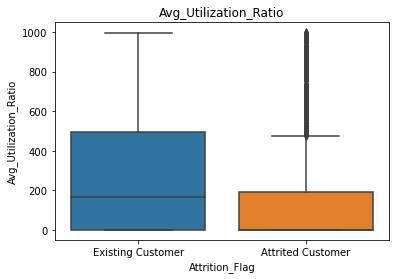

In [2]:
def plotColumn_vrs_target(df, colname, target):
    plt.figure(figsize=(10,5))
    plot = sns.countplot(x=df[colname], hue=df[target])
    plt.title(colname)
    
    for p in plot.patches:
        plot.annotate(p.get_height(), (p.get_x() + p.get_width()/3, p.get_height() +50)) #add data values and center them
    plt.show()

categorical = []
discrete = []
continuous = []

explicatory_vars = list(df.columns)
explicatory_vars.remove('CLIENTNUM')
explicatory_vars.remove('Attrition_Flag')

for colName in explicatory_vars:
    if df[colName].dtype == 'object':
        categorical.append(colName)
    elif df[colName].dtype in ['int64', 'float64'] and len(df[colName].unique()) <= 30:
        discrete.append(colName)
    else:
        continuous.append(colName)

categorical_and_discrete = categorical + discrete
for colName in categorical_and_discrete:
    plotColumn_vrs_target(df, colName,'Attrition_Flag')

for colName in continuous:
    sns.boxplot(x=df['Attrition_Flag'],y=df[colName])
    plt.title(colName)
    plt.show()

df_attrited = df[df['Attrition_Flag'] == 'Attrited Customer']
cantidadExisting = 2*df_attrited.shape[0]
df_existing = df[df['Attrition_Flag'] == 'Existing Customer'].sample(n=cantidadExisting,random_state=2023)
df = pd.concat([df_attrited, df_existing])

ohe_gender = pd.get_dummies(df['Gender'], drop_first=True)
df['Gender'] = ohe_gender

for colName in categorical:
    dict_for_encode = df[colName].value_counts().to_dict()
    df[colName]=df[colName].map(dict_for_encode)

df['Attrition_Flag'] = pd.get_dummies(df['Attrition_Flag'], drop_first=True)


3. Entrenamiento y validación de modelos

In [3]:
X = df.drop(['Attrition_Flag','CLIENTNUM'], axis =1)
y = df['Attrition_Flag']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=2023)

scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

# Logistic Regression
logit = LogisticRegression()
logit.fit(X_train_std, y_train)

# Decision Tree
dt = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=10).fit(X_train_std, y_train)

# ANN
ann_classifier = Sequential()
ann_classifier.add(Dense(units=200, kernel_initializer='uniform', activation='sigmoid'))
ann_classifier.add(Dense(units=100, kernel_initializer='uniform', activation='sigmoid'))
ann_classifier.add(Dense(units=200, kernel_initializer='uniform', activation='sigmoid'))
ann_classifier.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))
ann_classifier.compile(optimizer="adam", loss="binary_crossentropy", metrics=['accuracy'])
ann_classifier.fit(X_train_std, y_train, batch_size=20, epochs=150)


Epoch 1/150
171/171 [==============================] - 0s 1ms/step - loss: 0.6236 - accuracy: 0.6692
Epoch 2/150
171/171 [==============================] - 0s 1ms/step - loss: 0.4404 - accuracy: 0.8124
Epoch 3/150
171/171 [==============================] - 0s 1ms/step - loss: 0.4022 - accuracy: 0.8255
Epoch 4/150
171/171 [==============================] - 0s 965us/step - loss: 0.3878 - accuracy: 0.8317
Epoch 5/150
171/171 [==============================] - 0s 1ms/step - loss: 0.3725 - accuracy: 0.8343
Epoch 6/150
171/171 [==============================] - 0s 1ms/step - loss: 0.3672 - accuracy: 0.8393
Epoch 7/150
171/171 [==============================] - 0s 1ms/step - loss: 0.3612 - accuracy: 0.8375
Epoch 8/150
171/171 [==============================] - 0s 1ms/step - loss: 0.3592 - accuracy: 0.8399
Epoch 9/150
171/171 [==============================] - 0s 1ms/step - loss: 0.3585 - accuracy: 0.8375
Epoch 10/150
171/171 [==============================] - 0s 1ms/step - loss: 0.3538 - accu

4. Pruebas y evaluación de modelos

In [4]:
def print_metrics(y_test, y_preds, model_name):
    roc_auc = round(roc_auc_score(y_test, y_preds), 4)
    acc = round(accuracy_score(y_test, y_preds), 4)

    print(f"{model_name} Accuracy: {acc}")
    print(f"{model_name} ROC-AUC: {roc_auc}")

# Logistic Regression
logit_predicts = logit.predict(X_test_std)
print_metrics(y_test, logit_predicts, "Logistic Regression")

# Decision Tree
dt_predicts = dt.predict(X_test_std)
print_metrics(y_test, dt_predicts, "Decision Tree")

# ANN
y_preds = ann_classifier.predict(X_test_std)
ann_preds = (y_preds >= 0.5)
print_metrics(y_test, ann_preds, "ANN")

# Hyperparameters Tuning
hyperparams_grid = {
    'criterion':['gini', 'entropy', 'log_loss'],
    'splitter':['best','random'],
    'max_depth':[10,100]
}
grid_search_dt = GridSearchCV(estimator=dt, param_grid=hyperparams_grid, n_jobs=-1,refit='roc_auc',
                           scoring=['roc_auc', 'accuracy'],cv=KFold(n_splits=10, shuffle=True, random_state=2025))
grid_search_dt.fit(X_train_std,y_train)

rl = LogisticRegression()

hyperparams_grid = {
    'penalty': ['l2'],
    'C': [0.1, 1, 10, 50]
}

grid_search = GridSearchCV(estimator=rl, param_grid=hyperparams_grid, n_jobs=-1, refit='roc_auc',
                           scoring=['roc_auc', 'accuracy'], cv=KFold(n_splits=10, shuffle=True, random_state=2025))
grid_search.fit(X_train_std, y_train)

Logistic Regression Accuracy: 0.8594
Logistic Regression ROC-AUC: 0.8383
Decision Tree Accuracy: 0.8867
Decision Tree ROC-AUC: 0.8784
ANN Accuracy: 0.9167
ANN ROC-AUC: 0.9167


GridSearchCV(cv=KFold(n_splits=10, random_state=2025, shuffle=True),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 50], 'penalty': ['l2']},
             refit='roc_auc', scoring=['roc_auc', 'accuracy'])

# INVESTIGACION DE LOS MODELOS

### Regresion Logistica

La regresión logística es un algoritmo de aprendizaje supervisado que se utiliza para clasificación. Aunque su nombre incluye la palabra "regresión", se utiliza principalmente para tareas de clasificación.
La regresión logística funciona de manera similar a la regresión lineal, pero en lugar de predecir un valor continuo, predice la probabilidad de ocurrencia de un evento al ajustar los datos a una función logística.
La función logística (también llamada función sigmoidea) tiene una curva en forma de "S", y puede tomar cualquier número real y mapearlo en un valor entre 0 y 1. Si la probabilidad pronosticada es mayor que 0.5, el modelo predice que la instancia pertenece a la "clase positiva" (etiqueta 1); si es menor que 0.5, predice que pertenece a la "clase negativa" (etiqueta 0).
Es importante destacar que la regresión logística es un algoritmo de clasificación binaria, lo que significa que es adecuada para problemas con exactamente dos clases posibles. Sin embargo, puede extenderse a clasificación multiclase mediante técnicas como "uno contra todos" (one-vs-all) o "uno contra uno" (one-vs-one).

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score

# Crear y entrenar el modelo
rl = LogisticRegression()
rl.fit(X_train_std, y_train)

# Predecir en los datos de prueba
logit_predicts = rl.predict(X_test_std)

# Imprimir las métricas
print_metrics(y_test, logit_predicts, "Logistic Regression")

# Ajuste de hiperparámetros
hyperparams_grid = {
    'penalty': ['l2'],
    'C': [0.1, 1, 10, 50]
}

grid_search_rl = GridSearchCV(estimator=rl, param_grid=hyperparams_grid, n_jobs=-1, refit='roc_auc',
                           scoring=['roc_auc', 'accuracy'], cv=KFold(n_splits=10, shuffle=True, random_state=2025))

grid_search_rl.fit(X_train_std, y_train)


Logistic Regression Accuracy: 0.8594
Logistic Regression ROC-AUC: 0.8383


GridSearchCV(cv=KFold(n_splits=10, random_state=2025, shuffle=True),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 50], 'penalty': ['l2']},
             refit='roc_auc', scoring=['roc_auc', 'accuracy'])

### Árbol de Decisión

Un Árbol de Decisión es un tipo de modelo de aprendizaje automático supervisado que es principalmente utilizado para la clasificación, pero también puede ser útil para problemas de regresión. Es llamado "árbol de decisión" porque toma decisiones al dividir los datos en subconjuntos basándose en preguntas.
La estructura del árbol de decisión es similar a un árbol en la naturaleza, con la raíz en la parte superior, las ramas que salen de la raíz y las hojas en los extremos de las ramas.
La raíz y cada nodo interno representan una condición o pregunta sobre los datos.
Las ramas representan las respuestas a estas preguntas.
Cada hoja del árbol representa una decisión final (una clasificación o un valor de regresión).
Los árboles de decisión son populares porque son intuitivos y fáciles de entender. Su estructura proporciona una visualización clara de las decisiones que se están tomando y por qué se están tomando. Sin embargo, pueden ser propensos a sobreajuste si no se manejan correctamente.

In [6]:
from sklearn.tree import DecisionTreeClassifier

# Crear y entrenar el modelo
dt = DecisionTreeClassifier()
dt.fit(X_train_std, y_train)

# Predecir en los datos de prueba
dt_predicts = dt.predict(X_test_std)

# Imprimir las métricas
print_metrics(y_test, dt_predicts, "Decision Tree")

# Ajuste de hiperparámetros
hyperparams_grid = {
    'criterion':['gini', 'entropy', 'log_loss'],
    'splitter':['best','random'],
    'max_depth':[10,100]
}

grid_search_dt = GridSearchCV(estimator=dt, param_grid=hyperparams_grid, n_jobs=-1,refit='roc_auc',
                           scoring=['roc_auc', 'accuracy'],cv=KFold(n_splits=10, shuffle=True, random_state=2025))

grid_search_dt.fit(X_train_std,y_train)


Decision Tree Accuracy: 0.8805
Decision Tree ROC-AUC: 0.8684


GridSearchCV(cv=KFold(n_splits=10, random_state=2025, shuffle=True),
             estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [10, 100],
                         'splitter': ['best', 'random']},
             refit='roc_auc', scoring=['roc_auc', 'accuracy'])

### Red Neuronal Artificial (ANN)

Las Redes Neuronales Artificiales (ANN, por sus siglas en inglés) son un modelo de aprendizaje automático que intenta simular la manera en la que el cerebro humano funciona para procesar información. Son una parte fundamental del aprendizaje profundo, un subcampo del aprendizaje automático.
Las ANN están compuestas por nodos o "neuronas", organizados en capas. Cada neurona recibe una serie de inputs, los multiplica por pesos asociados, suma los resultados y aplica una función de activación al total para producir un output. Los pesos se ajustan durante el entrenamiento para mejorar la precisión del modelo.
Las capas en una ANN típicamente incluyen:
Capa de entrada: Recibe los datos de entrada y los pasa a la siguiente capa.
Capas ocultas: Estas son las capas entre la capa de entrada y la capa de salida. Cada neurona en una capa oculta toma las salidas de todas las neuronas en la capa anterior, realiza una serie de cálculos, y pasa su resultado a las neuronas en la próxima capa.
Capa de salida: Produce el resultado final del modelo.
Las ANN pueden aprender patrones complejos y no lineales, y son especialmente útiles para tareas como reconocimiento de imágenes, procesamiento de lenguaje natural, y predicción de series de tiempo. Sin embargo, pueden ser difíciles de interpretar y pueden requerir grandes cantidades de datos y poder de cómputo para entrenar de manera eficiente.

In [7]:
from keras.models import Sequential
from keras.layers import Dense

# Crear y entrenar el modelo
ann_classifier = Sequential()
ann_classifier.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu', input_dim = X_train_std.shape[1]))
ann_classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
ann_classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
ann_classifier.fit(X_train_std, y_train, batch_size = 10, epochs = 100, verbose=0)

# Predecir en los datos de prueba
y_preds = ann_classifier.predict(X_test_std)
ann_preds = (y_preds >= 0.5)

# Imprimir las métricas
print_metrics(y_test, ann_preds, "ANN")


ANN Accuracy: 0.8901
ANN ROC-AUC: 0.8761


### SVM (Support Vector Máchines)

Las Máquinas de Vectores de Soporte (SVM, por sus siglas en inglés) son un tipo de algoritmo de aprendizaje supervisado utilizado en clasificación y regresión. Aunque pueden utilizarse para problemas de regresión, son más conocidas y utilizadas para clasificación.
La idea principal detrás de SVM es encontrar un hiperplano que separe de manera óptima las clases en un espacio de características. En un problema de clasificación binaria, este hiperplano separa las dos clases de manera que la distancia entre las muestras más cercanas de cada clase (los "vectores de soporte") sea la máxima posible. Esta distancia se conoce como "margen" y el hiperplano se elige de forma que el margen sea máximo, lo que hace que el algoritmo sea resistente a la sobreajuste.
Si las clases no son linealmente separables, SVM puede utilizar lo que se llama una función de kernel para mapear los datos a un espacio de mayor dimensión en el que se pueda encontrar un hiperplano de separación. Las funciones de kernel más comunes incluyen polinomial, radial basis function (RBF), y sigmoid.
En resumen, SVM es un método poderoso y flexible para el aprendizaje supervisado que puede manejar tanto problemas de clasificación binaria como multiclase, así como regresión.

In [8]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, KFold

# Definir hiperparámetros a optimizar
hyperparams_grid = {'C': [0.1, 1, 10, 50], 'kernel': ['linear', 'rbf']}

# Crear una instancia del modelo
svm = SVC(random_state=2023)

# Optimizar hiperparámetros
grid_search_svm = GridSearchCV(estimator=svm, param_grid=hyperparams_grid, n_jobs=-1, refit='roc_auc', scoring=['roc_auc', 'accuracy'], cv=KFold(n_splits=10, shuffle=True, random_state=2025))
grid_search_svm.fit(X_train_std, y_train)

# Mejor combinación de hiperparámetros
print("Mejor combinación de hiperparámetros para SVM:", grid_search_svm.best_params_)

# Mejor puntuación (roc_auc) obtenida
print("Mejor puntuación roc_auc para SVM:", grid_search_svm.best_score_)


Mejor combinación de hiperparámetros para SVM: {'C': 1, 'kernel': 'rbf'}
Mejor puntuación roc_auc para SVM: 0.9455663391339666


### KNN (K-neárest neighbors)

El algoritmo de los K-nearest neighbors (KNN, por sus siglas en inglés) es un método simple y eficaz utilizado en la clasificación y la regresión en el aprendizaje automático. Se considera un método de aprendizaje basado en instancias o aprendizaje perezoso porque no aprende una función de mapeo de las características de entrada a la salida durante el entrenamiento. En cambio, almacena todo el conjunto de entrenamiento, que luego utiliza durante la fase de prueba para hacer predicciones.
En la clasificación, KNN predice la clase de una observación de prueba identificando las observaciones más cercanas en el conjunto de entrenamiento. Específicamente, encuentra los "K" puntos en el conjunto de datos de entrenamiento más cercanos al punto de prueba y asigna a este último la clase más común entre estos K puntos.
La distancia entre los puntos se puede calcular de varias maneras, pero la distancia euclídea es la más común. El valor de K es un parámetro que se puede ajustar y que puede afectar la precisión del modelo. Un valor pequeño de K puede hacer que el modelo sea sensible al ruido, mientras que un valor grande puede hacer que el modelo sea resistente al ruido pero menos preciso con las observaciones atípicas.
En resumen, KNN es un algoritmo de aprendizaje automático muy intuitivo y fácil de entender que puede ser eficaz para problemas de clasificación y regresión con suficientes datos de entrenamiento.

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, KFold

# Definición del modelo
knn = KNeighborsClassifier()

# Grid de hiperparámetros
hyperparams_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Definición de GridSearchCV
grid_search_knn = GridSearchCV(estimator=knn, param_grid=hyperparams_grid, n_jobs=-1, refit='roc_auc',
                           scoring=['roc_auc', 'accuracy'], cv=KFold(n_splits=10, shuffle=True, random_state=2025))

# Ajuste del modelo
grid_search_knn.fit(X_train_std, y_train)

# Mejor combinación de hiperparámetros
print("Mejor combinación de hiperparámetros para KNN:", grid_search_knn.best_params_)

# Mejor puntuación (roc_auc) obtenida
print("Mejor puntuación roc_auc para KNN:", grid_search_knn.best_score_)



Mejor combinación de hiperparámetros para KNN: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}
Mejor puntuación roc_auc para KNN: 0.9238148239233122


### NB (Náive Báyes)

Naive Bayes es una técnica de clasificación basada en el teorema de Bayes que asume que la presencia de una característica particular en una clase no está relacionada con la presencia de ninguna otra característica.
Incluso si estas características dependen entre sí o si están correlacionadas, todas estas propiedades se consideran de forma independiente para contribuir a la probabilidad. Por esta razón, es conocido como "naive" (ingenuo).
Naive Bayes es fácil de construir, rápido para la predicción de clases y funciona bien en conjuntos de datos multiclase. Aunque tiene una suposición de independencia bastante fuerte, en la práctica puede funcionar bastante bien incluso cuando esta suposición no se cumple en su totalidad.
Es especialmente adecuado para datos de alta dimensión y se utiliza comúnmente para la clasificación de texto, como en el filtrado de spam y la clasificación de documentos.

In [10]:
from sklearn.naive_bayes import GaussianNB

# Crear una instancia del modelo
nb = GaussianNB()

# Entrenar el modelo
nb.fit(X_train_std, y_train)

# Realizar predicciones
nb_predictions = nb.predict(X_test_std)

# Imprimir métricas
print(f"Accuracy NB: {accuracy_score(y_test, nb_predictions)}")
print(f"ROC-AUC NB: {roc_auc_score(y_test, nb_predictions)}")


Accuracy NB: 0.7972696245733788
ROC-AUC NB: 0.7851522842639594


### LDA (Lineár Discriminánt Análysis)

El Análisis Discriminante Lineal (Linear Discriminant Analysis, LDA) es un método estadístico utilizado para encontrar una combinación lineal de características que caracterizan o separan dos o más clases de objetos o eventos.
El resultado es un modelo lineal que maximiza la separación entre las clases. La idea es proyectar un conjunto de datos en un espacio de menor dimensión con una buena separación de clases para evitar el sobreajuste y reducir los costos computacionales.
LDA es particularmente útil cuando las categorías están bien separadas, y la distribución de los predictores X es aproximadamente normal en cada una de las categorías de respuesta.
En resumen, LDA transforma las entradas para maximizar la separabilidad de las clases. Es una técnica comúnmente utilizada para la reducción de la dimensionalidad y para la clasificación.

In [11]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Crear una instancia del modelo
lda = LinearDiscriminantAnalysis()

# Entrenar el modelo
lda.fit(X_train_std, y_train)

# Realizar predicciones
lda_predictions = lda.predict(X_test_std)

# Imprimir métricas
print(f"Accuracy LDA: {accuracy_score(y_test, lda_predictions)}")
print(f"ROC-AUC LDA: {roc_auc_score(y_test, lda_predictions)}")


Accuracy LDA: 0.8593856655290102
ROC-AUC LDA: 0.8420262267343486


### QDA (Quádrátic Discriminánt Análysis)

El Análisis Discriminante Cuadrático (Quadratic Discriminant Analysis, QDA) es un método estadístico utilizado en el reconocimiento de patrones y en el aprendizaje automático para clasificar observaciones en categorías.
Al igual que el Análisis Discriminante Lineal (LDA), QDA se utiliza para separar observaciones en clases o categorías. Sin embargo, a diferencia de LDA, QDA no asume que las covarianzas de cada una de las clases son iguales.
Esto significa que QDA puede modelar una elipse en lugar de un hiperplano como en LDA, proporcionando una superficie de decisión más flexible para la clasificación.
En resumen, QDA es una extensión de LDA que permite una mayor flexibilidad en la forma de la superficie de decisión, a costa de una mayor complejidad y, potencialmente, un sobreajuste.

In [12]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# Crear una instancia del modelo
qda = QuadraticDiscriminantAnalysis()

# Entrenar el modelo
qda.fit(X_train_std, y_train)

# Realizar predicciones
qda_predictions = qda.predict(X_test_std)

# Imprimir métricas
print(f"Accuracy QDA: {accuracy_score(y_test, qda_predictions)}")
print(f"ROC-AUC QDA: {roc_auc_score(y_test, qda_predictions)}")


Accuracy QDA: 0.8320819112627986
ROC-AUC QDA: 0.8174492385786803


C:\Users\nidia\anaconda3\envs\myenv\lib\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
